In [1]:
seed = 0
dir_data = '../data'
path_ckpt = '../ckpt/1696079822/last_ckpt.bin'

In [2]:
import sys
sys.path.append('../')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from tqdm import tqdm

import torch
import torch.nn.functional as F

from transformers import Mask2FormerImageProcessor
from segformers.utils import custom_cmap, rle_encode
from segformers.networks import Mask2Former



/home/dongjin/miniconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b5-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([19, 768, 1, 1]) in the checkpoint and torch.Size([13, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([19]) in the checkpoint and torch.Size([13]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-large-ci

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

state_dict = torch.load(path_ckpt)
model = Mask2Former
model.load_state_dict(state_dict['model_state_dict'])
model.to(device);

image_processor = Mask2FormerImageProcessor.from_pretrained("facebook/mask2former-swin-large-cityscapes-semantic")
image_processor.do_resize = False

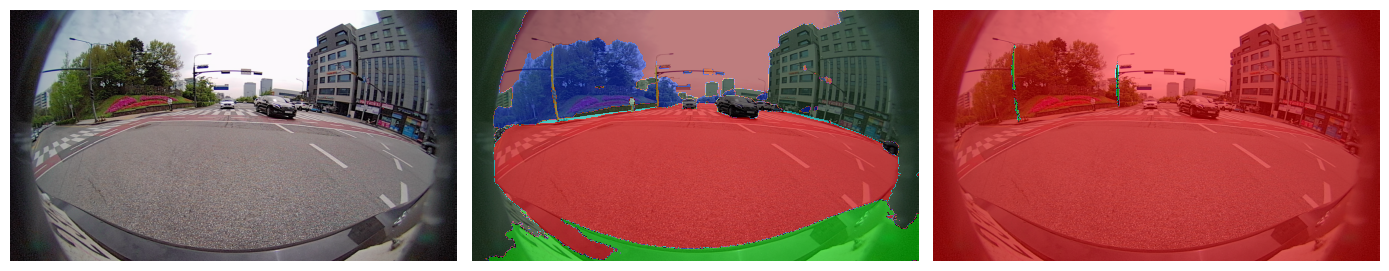

In [4]:
df = pd.read_csv(os.path.join(dir_data, 'test.csv'))

shape = (1080, 1920)
idx = 251
img_path = os.path.join(dir_data, df.loc[idx, 'img_path'])
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, shape[::-1])
normalized_image = A.Normalize()(image=image)['image']

images = torch.as_tensor(normalized_image, dtype=torch.float, device=device).permute(2, 0, 1).unsqueeze(0)
with torch.no_grad():
    outputs = model(images)
    class_queries_logits = outputs.class_queries_logits
    masks_queries_logits = outputs.masks_queries_logits

    masks_queries_logits = torch.nn.functional.interpolate(
                masks_queries_logits, size=(384, 384), mode="bilinear", align_corners=False
            )
    masks_classes = class_queries_logits.softmax(dim=-1)[..., :-1]
    masks_probs = masks_queries_logits.sigmoid()
    segmentation = torch.einsum("bqc, bqhw -> bchw", masks_classes, masks_probs)
    logits = crop_seg_logit = F.interpolate(
                segmentation,
                size=shape,
                mode="bilinear",
                align_corners=False
            )
masks = torch.argmax(logits, dim=1).cpu().numpy()

fig, ax = plt.subplots(1, 3, figsize=(14, 10))

ax[0].axis('off')
ax[0].imshow(image)

ax[1].axis('off')
ax[1].imshow(image)
im = ax[1].imshow(masks[0], alpha=0.5, cmap=custom_cmap)

ax[2].axis('off')
ax[2].imshow(image)
im = ax[2].imshow(masks[0] == 4, alpha=0.5, cmap=custom_cmap)

fig.tight_layout()
    

In [8]:
df = pd.read_csv(os.path.join(dir_data, 'test.csv'))

result = []
for idx in tqdm(range(len(df))):
    img_path = os.path.join(dir_data, df.loc[idx, 'img_path'])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (1920, 1080))
    normalized_image = A.Normalize()(image=image)['image']

    images = torch.as_tensor(normalized_image, dtype=torch.float, device=device).permute(2, 0, 1).unsqueeze(0)
    with torch.no_grad():
        outputs = model(images)
        class_queries_logits = outputs.class_queries_logits
        masks_queries_logits = outputs.masks_queries_logits

        masks_queries_logits = torch.nn.functional.interpolate(
                    masks_queries_logits, size=(384, 384), mode="bilinear", align_corners=False
                )
        masks_classes = class_queries_logits.softmax(dim=-1)[..., :-1]
        masks_probs = masks_queries_logits.sigmoid()
        segmentation = torch.einsum("bqc, bqhw -> bchw", masks_classes, masks_probs)
        logits = crop_seg_logit = F.interpolate(
                    segmentation,
                    size=shape,
                    mode="bilinear",
                    align_corners=False
                )

    masks = torch.argmax(logits, dim=1).cpu().numpy()[0]
    masks = cv2.resize(masks, (960, 540), interpolation=cv2.INTER_NEAREST)

    predictions = masks.astype(np.int32)
    for class_id in range(12):
        class_mask = (predictions == class_id).astype(np.int32)
        if np.sum(class_mask) > 0: # 마스크가 존재하는 경우 encode
            mask_rle = rle_encode(class_mask)
            result.append(mask_rle)
        else: # 마스크가 존재하지 않는 경우 -1
            result.append(-1)

100%|██████████| 1898/1898 [2:02:58<00:00,  3.89s/it] 


In [9]:
import pandas as pd

submit = pd.read_csv('../data/sample_submission.csv')
submit['mask_rle'] = result
submit

,id,mask_rle
0,TEST_0000_class_0,213597 6 214554 23 215496 48 216447 61 217389 ...
1,TEST_0000_class_1,-1
2,TEST_0000_class_2,1 107 598 126 729 339 1558 125 1689 340 2517 1...
3,TEST_0000_class_3,204837 19 205799 28 206693 7 206719 4 206760 4...
4,TEST_0000_class_4,-1
...,...,...
22771,TEST_1897_class_7,153209 8 154167 12 155125 15 155149 8 156084 1...
22772,TEST_1897_class_8,88 548 676 129 852 25 1047 548 1637 127 1812 2...
22773,TEST_1897_class_9,-1
22774,TEST_1897_class_10,-1


In [10]:
submit.to_csv('./m2f.csv', index=False)